klasifikasi hama dan penyakit daun kapas berdasarkan warna menggunakan Multi Layer Perceptron (MLP)

In [ ]:
import os
import cv2
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# momen warna (mean, std, skewness) dari setiap saluran warna
def color_moments(image):
    # momen warna untuk setiap saluran (Red, Green, Blue)
    mean = np.mean(image, axis=(0, 1))  # Rata-rata
    std = np.std(image, axis=(0, 1))    # Deviasi standar
    skewness = np.mean((image - mean) ** 3, axis=(0, 1)) / (std ** 3)  # Kemiringan (Skewness)
    return np.concatenate([mean, std, skewness])

# color_moments
image_path = '/content/drive/MyDrive/40 Images/Aphids/1.jpg'  # Ganti dengan path gambar Anda
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi ke RGB

# momen warna untuk gambar
features = color_moments(image)

print("Fitur warna yang diekstraksi (mean, std, skewness) untuk gambar:")
print(features)

Fitur warna yang diekstraksi (mean, std, skewness) untuk gambar:
[110.41265071 145.35789452  69.75012836  41.63581605  40.94785061
  38.42032162  -0.18382856  -0.6212884    0.30960557]


In [ ]:
# fitur warna dari gambar
def load_dataset(dataset_path):
    features = []
    labels = []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            # Menelusuri setiap gambar dalam folder
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)

                if file_path.endswith(('.jpg', '.png', '.jpeg')):
                    # Membaca gambar
                    image = cv2.imread(file_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # konversi RGB

                    # Menghitung fitur warna menggunakan momen warna
                    features.append(color_moments(image))
                    labels.append(folder)

    return np.array(features), np.array(labels)

    # Path folder dataset di Google Drive
dataset_path = '/content/drive/MyDrive/40 Images'

# Memuat dataset
features, labels = load_dataset(dataset_path)

print(f"Jumlah gambar yang dimuat: {len(features)}")
print(f"Jumlah label yang dimuat: {len(labels)}")

Jumlah gambar yang dimuat: 965
Jumlah label yang dimuat: 965


In [ ]:
# Path ke folder dataset di Google Drive
dataset_path = '/content/drive/MyDrive/40 Images'
features, labels = load_dataset(dataset_path)


features, labels = shuffle(features, labels, random_state=42)
le = LabelEncoder()
labels = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Jumlah data latih: {len(X_train)}")
print(f"Jumlah data uji: {len(X_test)}")

Jumlah data latih: 772
Jumlah data uji: 193


In [ ]:
# Melatih model MLP
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
print("Model MLP berhasil dilatih.")

Model MLP berhasil dilatih.


Found 965 images belonging to 6 classes.


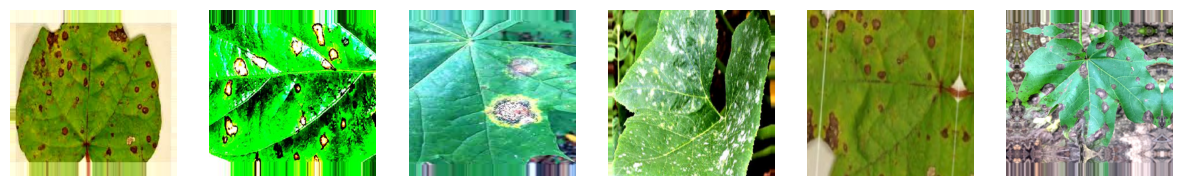

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Inisialisasi ImageDataGenerator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Memuat data dengan generator
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/40 Images',  # Ganti dengan path dataset Anda
    target_size=(500, 500),     # Ukuran gambar yang diinginkan
    batch_size=32,
    class_mode='categorical'    # Sesuaikan dengan label Anda
)

# Ambil satu batch gambar untuk ditampilkan
batch_images, batch_labels = next(train_generator)

# Fungsi untuk menampilkan gambar
def show_augmented_images(images, num_images=6):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Menampilkan gambar hasil augmentasi
show_augmented_images(batch_images, num_images=6)


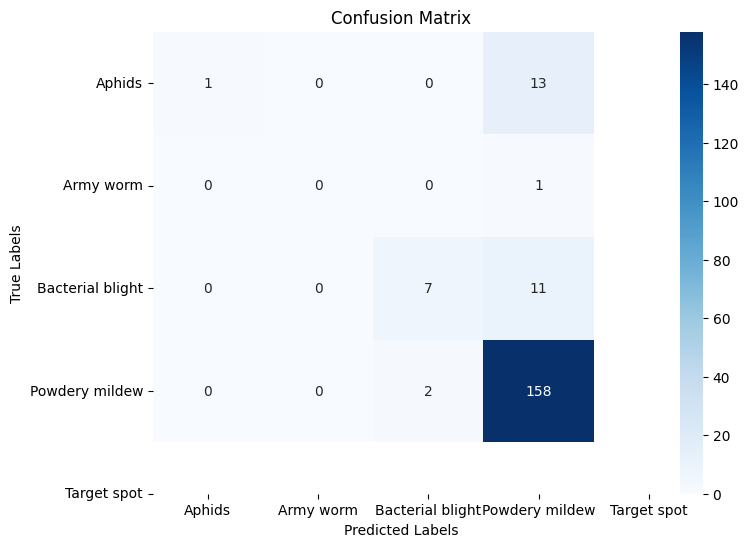

In [ ]:
# Import library yang diperlukan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# prediksi dengan data uji
y_pred = mlp.predict(X_test) # This line is added to calculate y_pred

#Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# prediksi dengan data uji
y_pred = mlp.predict(X_test)

# Menghitung dan menampilkan akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model MLP:", accuracy)

# Get unique labels in y_test and y_pred
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter le.classes_ to only include labels present in predictions
target_names = [le.classes_[i] for i in unique_labels]

# laporan klasifikasi
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred, target_names=target_names, labels=unique_labels))

Akurasi Model MLP: 0.8601036269430051

Laporan Klasifikasi:
                   precision    recall  f1-score   support

          Aphids       1.00      0.07      0.13        14
Bacterial blight       0.00      0.00      0.00         1
  Powdery mildew       0.78      0.39      0.52        18
     Target spot       0.86      0.99      0.92       160

        accuracy                           0.86       193
       macro avg       0.66      0.36      0.39       193
    weighted avg       0.86      0.86      0.82       193



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


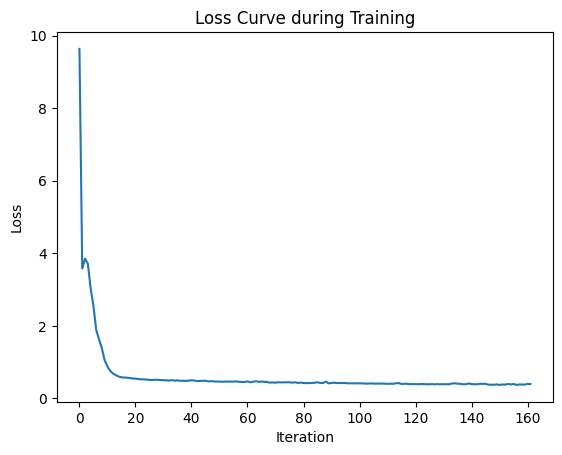

In [ ]:
# Plot hasil akurasi
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve during Training')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()